In [1]:
import csv
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter
from PIL import Image
import numpy as np
import cv2
import gc
from sklearn.model_selection import train_test_split
import os
import csv
import sklearn
import random # for shuffle
import time

gc.collect()
#import h5py

# keras_tqdm = keras progress bar (some bugs without)
# https://pypi.python.org/pypi/keras-tqdm
# http://forums.fast.ai/t/jupyter-notebook-dies-freezes-during-training/2651/4
from keras_tqdm import TQDMNotebookCallback

import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Cropping2D, Lambda
from keras.layers import Conv2D, Dropout, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
import kerasvis

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


# NOTES FOR WRITEUP
# data - intially provided data
# a2 - extra data
# a3 - extra data from harder track
# a4 - extra data reverse
# a5 - 


Using TensorFlow backend.


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8423361828263830275
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 7768827495
locality {
  bus_id: 1
}
incarnation: 15593128673671223761
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0"
]


In [2]:
samples = []
first = True
with open('../DATA0/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if not first:
            samples.append(line)
        else:
            first = False
            
random.shuffle(samples)

print(len(samples))




#print(len(samples))
#print(samples[0])

10404


In [3]:
#X, y = read_training_data_into_memory(samples)


In [4]:
# driving_log.csv - header
# center,left,right,steering,throttle,brake,speed

# dealing with unbalanced data with class_weight
# https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

#from sklearn.utils import class_weight
import sklearn.utils.class_weight

def generator(samples,batch_size=32, image_prefix_path="../DATA0/IMG/"):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            angle_offsets = [0.0, 0.20, -0.20]
            
            for batch_sample in batch_samples:
                center_angle = float(batch_sample[3])

                for image_position in range(3):
                    image_subpath = batch_sample[image_position].split('/')[-1]
                    image_path = image_prefix_path + image_subpath
                    image = cv2.imread(image_path)
                    images.append(image)
                    angle = center_angle + angle_offsets[image_position]
                    angles.append(angle)

                    # also add flipped image and angle
                    flipped_image = np.fliplr(image)
                    flipped_angle_for_image = -angle
                    images.append(flipped_image)
                    angles.append(flipped_angle_for_image)
         
            # trim image to only see section with road
            X_train = np.array(images)
            #print(X_train.shape)
            y_train = np.array(angles)
            
            #class_weight = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
            sample_weight = sklearn.utils.class_weight.compute_sample_weight('balanced', y_train)
            
            #print(y_train)
            #print(class_weight)
            #print(sample_weight)
            #print(X_train.shape)
            #print(y_train.shape)
            #print(class_weight.shape)
            #print(sample_weight.shape)

            
            yield sklearn.utils.shuffle(X_train, y_train, sample_weight)

In [5]:
#X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)
#print(len(X_train), len(X_validation))
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print(len(train_samples), len(validation_samples))

BATCH_SIZE = 64 # 32 and 64 works mem wise! iteration for 32 is 90s per epoch, around 58 for 64

8323 2081


In [6]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)

# just for visualization


In [7]:
#X_train = np.array(images)
#y_train = np.array(measurements)

In [8]:
#print(X_train.shape)
#print(y_train.shape)

In [9]:
img_input_shape=(160,320,3)
#batch_size=256
#epochs=15

# Crop the image - top 50px and bottom 0px
# ((top_crop, bottom_crop), (left_crop, right_crop)) = 
crop_pattern = ((50,25),(0,0))
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=img_input_shape))
model.add(Cropping2D(cropping=crop_pattern))
model.add(Conv2D(24,(5,5),padding='valid', activation='relu', strides=(2,2), kernel_regularizer='l2',
                kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Conv2D(36,(5,5),padding='valid', activation='relu', strides=(2,2), kernel_regularizer='l2',
                kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(48,(5,5),padding='valid', activation='relu', strides=(2,2), kernel_regularizer='l2'))
model.add(Conv2D(64,(3,3),padding='valid', activation='relu', strides=(1,1), kernel_regularizer='l2'))
model.add(Flatten())
model.add(Dense(400, activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='selu'))
model.add(Dropout(0.25))
model.add(Dense(50, activation='selu'))
model.add(Dense(10, activation='selu'))
model.add(Dense(1,kernel_regularizer='l1', activation='tanh'))


model.compile(loss='mse', optimizer='adam')

In [10]:
for layer in model.layers:
    print(type(layer))

<class 'keras.layers.core.Lambda'>
<class 'keras.layers.convolutional.Cropping2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.pooling.MaxPooling2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.normalization.BatchNormalization'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.convolutional.Conv2D'>
<class 'keras.layers.core.Flatten'>
<class 'keras.layers.core.Dense'>
<class 'keras.layers.core.Dropout'>
<class 'keras.layers.core.Dense'>
<class 'keras.layers.core.Dropout'>
<class 'keras.layers.core.Dense'>
<class 'keras.layers.core.Dense'>
<class 'keras.layers.core.Dense'>


In [11]:
import pydot
model.summary()


#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 85, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 158, 24)       1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 41, 158, 24)       96        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 79, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 38, 36)         21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 38, 36)         144       
__________

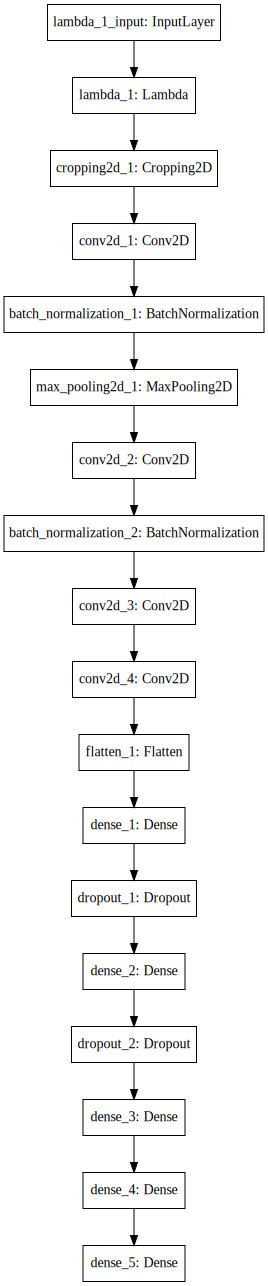

In [12]:
#from keras.utils import plot_model
# show model architecture
#plt.figure(figsize=(20,20))
#plot_model(model, to_file='model.png')
#plt.imshow(cv2.imread('model.png'))
#plt.show()

# SVG visualization worked better than above.
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [13]:
# visualization of training with kerasvis
kerasvis_logger = kerasvis.DBLogger(comment="train_car_to_drive")

DBLogger(2, "train_car_to_drive")


In [14]:
model.fit_generator(train_generator, steps_per_epoch=int(6*len(train_samples)/BATCH_SIZE),
                    validation_data = validation_generator,
                    validation_steps = int(6*len(validation_samples)/BATCH_SIZE), epochs=5,
                    verbose=2, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True), 
                                         kerasvis_logger])

# verbose = 0, callbacks=[TQDMNotebookCallback()]
                    
          #batch_size=batch_size,
#          epochs=epochs,
#          verbose=1,
#          shuffle = True,
#          validation_split=0.3)



#!pip install h5py
import h5py as h5py
model.save('model.h5')

Epoch 1/5
178s - loss: 0.2916 - val_loss: 0.0603
Epoch 2/5
180s - loss: 0.0530 - val_loss: 0.0463
Epoch 3/5
181s - loss: 0.0398 - val_loss: 0.0330
Epoch 4/5
179s - loss: 0.0309 - val_loss: 0.0326
Epoch 5/5
178s - loss: 0.0302 - val_loss: 0.0312

